In [13]:
import torch
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [14]:
# import os
# import pandas as pd
# from PIL import Image
# from torch.utils.data import Dataset
# import torch

# class RAFDBDataset(Dataset):
#     def __init__(self, csv_file, img_dir, transform=None):
#         self.labels = pd.read_csv(csv_file)
#         self.img_dir = img_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
#         image = Image.open(img_name)
#         label = self.labels.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)

#         return image, label

In [15]:
from rafdb_dataset import RAFDBDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

rafdb_dataset_train = RAFDBDataset(csv_file='archive/train_labels.csv',
                             img_dir='archive/DATASET/train',
                             transform=transform)

rafdb_dataset_test = RAFDBDataset(csv_file='archive/test_labels.csv',
                            img_dir='archive/DATASET/test',
                            transform=transform)

In [16]:
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=64, shuffle=True, num_workers=4)

data_test_loader = DataLoader(rafdb_dataset_test, batch_size=64, shuffle=False, num_workers=0)

In [17]:
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

Train batch: image shape torch.Size([64, 3, 64, 64]), labels shape torch.Size([64])


In [18]:
test_image, test_label = next(iter(data_test_loader))
print(f"Train batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([64, 3, 64, 64]), labels shape torch.Size([64])


In [19]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 6)

    def forward(self, x):
        x = F.relu(self.bn1(F.max_pool2d(self.conv1(x), 2)))
        x = F.relu(self.bn2(F.max_pool2d(self.conv2(x), 2)))
        x = F.relu(self.bn3(F.max_pool2d(self.conv3(x), 2)))
        x = self.pool(x)
        x = x.view(-1, 128)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [20]:
model = EmotionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"), 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(data_train_loader)}")


Epoch 1/10: 100%|██████████| 192/192 [00:29<00:00,  6.52it/s]


Epoch 1, Loss: 0.7049966819273928


Epoch 2/10: 100%|██████████| 192/192 [00:28<00:00,  6.75it/s]


Epoch 2, Loss: 0.4725764205989738


Epoch 3/10: 100%|██████████| 192/192 [00:28<00:00,  6.76it/s]


Epoch 3, Loss: 0.3736759307018171


Epoch 4/10: 100%|██████████| 192/192 [00:28<00:00,  6.76it/s]


Epoch 4, Loss: 0.29390638158656657


Epoch 5/10: 100%|██████████| 192/192 [00:28<00:00,  6.75it/s]


Epoch 5, Loss: 0.21841503047229102


Epoch 6/10: 100%|██████████| 192/192 [00:28<00:00,  6.77it/s]


Epoch 6, Loss: 0.14784758466218287


Epoch 7/10: 100%|██████████| 192/192 [00:28<00:00,  6.64it/s]


Epoch 7, Loss: 0.09975170819476868


Epoch 8/10: 100%|██████████| 192/192 [00:28<00:00,  6.70it/s]


Epoch 8, Loss: 0.06391832462395541


Epoch 9/10: 100%|██████████| 192/192 [00:28<00:00,  6.69it/s]


Epoch 9, Loss: 0.05833938762104177


Epoch 10/10: 100%|██████████| 192/192 [00:29<00:00,  6.52it/s]

Epoch 10, Loss: 0.02831483645119685


In [21]:
def test_model(model, test_loader, device, criterion):
    model.eval()  
    test_loss = 0.0
    correct = 0
    total = 0
    losses = []
    accuracies = []

    with torch.no_grad(): 
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            losses.append(loss.item())
            accuracies.append(100.0 * (predicted == labels).sum().item() / labels.size(0))

    average_loss = test_loss / len(test_loader)
    average_accuracy = 100 * correct / total
    print(f'Average Loss: {average_loss:.4f}, Accuracy: {average_accuracy:.2f}%')

    return losses, accuracies

Average Loss: 0.6146, Accuracy: 60.79%


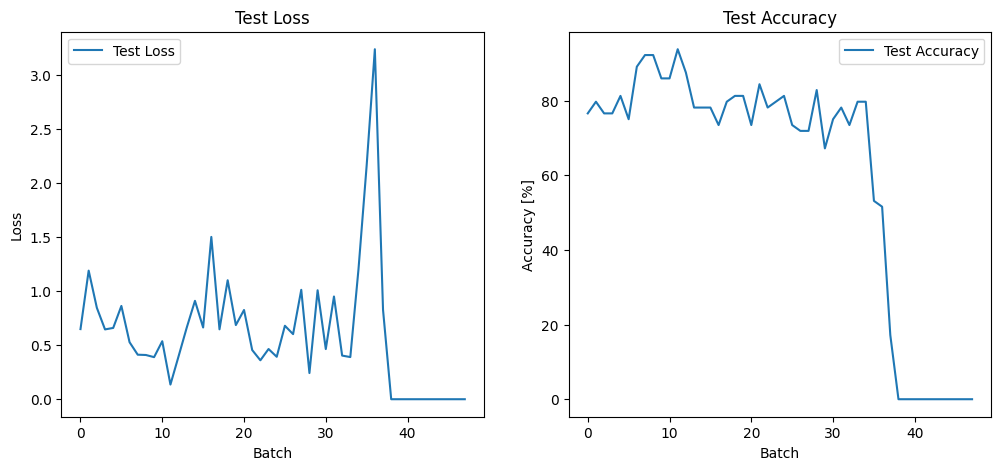

In [22]:
losses, accuracies = test_model(model, data_test_loader, device, criterion)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy [%]')
plt.legend()

plt.show()